In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
import glob
import pickle
import time
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
import math
from sklearn.base import clone
!pip install scikit-optimize
from skopt import gp_minimize
!pip install hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt import space_eval
!pip install keras
!pip install tensorflow
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
!pip install h5py
from keras.models import load_model

Using TensorFlow backend.


In [2]:
# calendar_dfs = []
# for file_name in glob.glob('./data/amsterdam/calendar*.gz'):
#     calendar_dfs.append(pd.read_csv(file_name, compression='gzip'))
# calendar = pd.concat(calendar_dfs, sort=True)

In [3]:
# reviews_dfs = []
# for file_name in glob.glob('./data/amsterdam/reviews*.gz'):
#     reviews_dfs.append(pd.read_csv(file_name, compression='gzip'))
# reviews = pd.concat(reviews_dfs, sort=True)

In [4]:
# listings_dfs = []
# for file_name in glob.glob('./data/amsterdam/listings*.gz'):
#     listings_dfs.append(pd.read_csv(file_name, compression='gzip', dtype="str"))
# listings = pd.concat(listings_dfs, sort=True)

## Data Preparation

In [5]:
calendar = pd.read_csv("./data/boston/calendar.csv")
reviews = pd.read_csv("./data/boston/reviews.csv")
listings = pd.read_csv("./data/boston/listings.csv")

### Transforming 'price' from string to numeric

In [6]:
"""
    Converts price in the string format like "$1,125.00" into numeric value 1125.00
    INPUT:
    - string price in string format
    OUTPUT:
    - float value corresponding to the price or None if the input is not parseable to float
"""
def str_to_num (string):
    if string is not None:
        if type(string) is str and string.startswith('$'):
            return float(string.replace('$', '').replace(',', ''))
        else:
            return None
    else:
        return None
listings_cleaned = pd.concat([listings.drop('price', axis=1), listings["price"].apply(str_to_num)], axis=1)
listings_cleaned['price'].head()

0    250.0
1     65.0
2     65.0
3     75.0
4     79.0
Name: price, dtype: float64

In [7]:
calendar_cleaned = pd.concat([calendar.drop('price', axis=1), calendar["price"].apply(str_to_num)], axis=1)
calendar_cleaned['price'].head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: price, dtype: float64

### Converting 'avilable' field from string to binary

In [8]:
calendar_cleaned['available'] = calendar_cleaned['available'] == 't'
calendar_cleaned['available'].head()

0    False
1    False
2    False
3    False
4    False
Name: available, dtype: bool

### Converting 'date' from string to datetime format

In [9]:
calendar_cleaned["date"] = pd.to_datetime(calendar_cleaned["date"], format="%Y-%m-%d")

### Converting location field from numeric to categorical

In [10]:
listings_cleaned["location_categorical"] = listings_cleaned.apply(lambda row: str((format(row.latitude, '.2f'), format(row.longitude, '.2f'))), axis=1)

In [11]:
listings_cleaned.location_categorical.head()

0    ('42.28', '-71.13')
1    ('42.29', '-71.13')
2    ('42.29', '-71.14')
3    ('42.28', '-71.12')
4    ('42.28', '-71.14')
Name: location_categorical, dtype: object

### Converting 'amenities' field containing list into separate categorical columns for each amenity in dataframe

In [12]:
list(map(lambda amenity : amenity.replace("\"","").replace("{","").replace("}", ""), listings_cleaned.amenities.iloc[0].split(",")))

['TV',
 'Wireless Internet',
 'Kitchen',
 'Free Parking on Premises',
 'Pets live on this property',
 'Dog(s)',
 'Heating',
 'Family/Kid Friendly',
 'Washer',
 'Dryer',
 'Smoke Detector',
 'Fire Extinguisher',
 'Essentials',
 'Shampoo',
 'Laptop Friendly Workspace']

In [13]:
"""
    Separates the string value of `amenities` attribute in the row, into a list of individual amenities.
    
    INPUT:
    - row : from dataset having amenities attribute
    OUTPUT:    
    - list of amenities derived from the value of `amenities` attribute in row
"""
def separate_amenities(row):
    amenities = row.amenities
    list_to_return = []
    if (amenities is not None and type(amenities) == str):            
        list_to_return = list(map(lambda amenity : amenity.replace("\"","").replace("{","").replace("}", ""), amenities.split(",")))
    if '' in list_to_return:
        list_to_return.remove('')
    return list_to_return
listings_cleaned["amenities_list"] = listings_cleaned.apply(separate_amenities, axis=1)

In [ ]:
possible_amenities = listings_cleaned['amenities_list'].apply(pd.Series).stack().unique()
possible_amenities

array(['TV', 'Wireless Internet', 'Kitchen', 'Free Parking on Premises',
       'Pets live on this property', 'Dog(s)', 'Heating',
       'Family/Kid Friendly', 'Washer', 'Dryer', 'Smoke Detector',
       'Fire Extinguisher', 'Essentials', 'Shampoo',
       'Laptop Friendly Workspace', 'Internet', 'Air Conditioning',
       'Pets Allowed', 'Carbon Monoxide Detector', 'Lock on Bedroom Door',
       'Hangers', 'Hair Dryer', 'Iron', 'Cable TV', 'First Aid Kit',
       'Safety Card', 'translation missing: en.hosting_amenity_49',
       'translation missing: en.hosting_amenity_50', 'Gym', 'Breakfast',
       'Indoor Fireplace', 'Cat(s)', '24-Hour Check-in', 'Hot Tub',
       'Buzzer/Wireless Intercom', 'Other pet(s)', 'Washer / Dryer',
       'Smoking Allowed', 'Suitable for Events', 'Wheelchair Accessible',
       'Elevator in Building', 'Pool', 'Doorman',
       'Paid Parking Off Premises', 'Free Parking on Street'],
      dtype=object)

In [ ]:
"""
    Assigns new boolean attribute to the row based on the presence of that amenity in the list.
    Returns updated row with additional attributes corresponding to the amenities added to it.
    
    INPUT:
    - row containing attributes related to the property, including `amenities_list`
    OUTPUT:
    - row containing newly added boolean attributes indicating the presence of each possible type of amenity in the property
"""
def add_amenities_columns (row):
    amenities = set(row.amenities_list)
    for possible_amenity in possible_amenities:
        row["amenity_" + possible_amenity] = possible_amenity in amenities
    return row

listings_cleaned = listings_cleaned.apply(add_amenities_columns, axis=1)

### Identifying the activation date for each property listing

In [ ]:
df = calendar_cleaned
df = df.groupby('listing_id', group_keys=False)\
    .apply(lambda x: x[x.available.ne(x.available.shift())])\
    .reset_index(drop=True)
df.head(20)

,listing_id,date,available,price
0,3353,2017-09-05,True,36.0
1,3353,2016-12-30,False,NaN
2,3353,2017-08-18,True,36.0
3,3353,2016-10-12,False,NaN
4,5506,2017-09-05,True,145.0
5,5506,2016-10-10,False,NaN
6,5506,2016-10-03,True,145.0
7,5506,2016-09-30,False,NaN
8,5506,2016-09-28,True,145.0
9,5506,2016-09-25,False,NaN


In [ ]:
listing_activation_dates = df[df.available == True].groupby("listing_id")[["listing_id","date"]].min()

In [ ]:
listing_activation_dates.sort_values(by=["date"]).head()

,listing_id,date
listing_id,,
530983,530983,2016-09-06
815639,815639,2016-09-06
12726343,12726343,2016-09-06
2776391,2776391,2016-09-06
10524612,10524612,2016-09-06


### Only retaining entries in calendar for each property after its activation date

In [ ]:
cal_by_listing_groups = calendar_cleaned.groupby(["listing_id"])

In [ ]:
cal_by_listing_groups.head()

,listing_id,date,available,price
0,12147973,2017-09-05,False,NaN
1,12147973,2017-09-04,False,NaN
2,12147973,2017-09-03,False,NaN
3,12147973,2017-09-02,False,NaN
4,12147973,2017-09-01,False,NaN
365,3075044,2017-08-22,True,65.0
366,3075044,2017-08-21,True,65.0
367,3075044,2017-08-20,True,65.0
368,3075044,2017-08-19,True,75.0
369,3075044,2017-08-18,True,75.0


In [ ]:
def select_entries_after_activation_date(g):

    listing_id = g.name
    activation_date_df = listing_activation_dates.query("listing_id == @listing_id")["date"]
    if activation_date_df.shape[0] > 0:        
        activation_date = activation_date_df.iloc[0]
#         print("activatation_date: " + str(activation_date))
#         print(g["date"].dtype)
#         print(type(activation_date))
        return g[g["date"] <= activation_date]
    
    
cal_after_activation_dates =cal_by_listing_groups.apply(select_entries_after_activation_date)

### Select and add necessary variables to be used for predicting occupancy of property at given time of the year

In [ ]:
input_vars_from_listings = ["neighbourhood_cleansed", 
#                 "neighbourhood_group_cleansed",
                "city",
                "state",
                "zipcode",
                "market",
                "location_categorical",
                "property_type",
                "room_type",
                "accommodates",
                "bathrooms",
                "bedrooms",
                "beds",
                "bed_type",
                "square_feet",
                "guests_included",
                "minimum_nights",
                "maximum_nights",
                "review_scores_rating",
                "review_scores_accuracy",
                  "review_scores_cleanliness",
                  "review_scores_checkin",
                  "review_scores_communication",
                  "review_scores_location",
                  "review_scores_value",
#                   "jurisdiction_names",
                  "cancellation_policy",
#                   "reviews_per_month",
                  "number_of_reviews"
       ]
amenity_variables = list(map(lambda amenity : "amenity_" + amenity, possible_amenities))
input_vars_from_listings.extend(amenity_variables)


In [ ]:
calendar_cleaned["month"] = calendar_cleaned['date'].dt.month_name()

In [ ]:
calendar_cleaned["day_of_week"] = calendar_cleaned['date'].dt.weekday_name

In [ ]:
calendar_cleaned["week_of_month"] = np.ceil(calendar_cleaned['date'].dt.day/7).astype(int)

In [ ]:
calendar_cleaned["week_of_month"].unique()

array([1, 5, 4, 3, 2])

In [ ]:
df = pd.merge(listings_cleaned, calendar_cleaned, left_on="id", right_on="listing_id", how="inner", suffixes=("_listings", "_calendar"))

In [ ]:
g = df.groupby(["listing_id", "month", "day_of_week"]).apply(lambda x: x.sort_values(by=["date"]))

In [ ]:
g.loc[:, "price_calendar"] = g["price_calendar"].fillna(method="ffill")

In [ ]:
df = g.reset_index(drop=True)

In [ ]:
g = df.groupby(["listing_id"]).apply(lambda x: x.sort_values(by=["date"]))

In [ ]:
g.loc[:, "price_calendar"] = g["price_calendar"].fillna(method="ffill")

In [ ]:
df = g.reset_index(drop=True)

In [ ]:
input_vars_from_calendar = ["month", "day_of_week", "week_of_month", "price_calendar"]

In [ ]:
all_input_vars = input_vars_from_listings + input_vars_from_calendar;

In [ ]:
df = df.dropna(subset=["available"])

Select a sample of properties to be used as an environment of alternatives competing with the property to be booked that can have impact on whether the given property gets booked or not.

In [ ]:
start_date = df["date"].min()

In [ ]:
listing_ids_environment = list(df.query("date == @start_date").drop_duplicates(['listing_id'])["listing_id"].sample(100, random_state=42))

In [ ]:
X_with_env = df[all_input_vars + ["listing_id", "date"]].query("listing_id not in @listing_ids_environment")
for listing_id in listing_ids_environment:
    listing_price_availability = df.query("listing_id == @listing_id")[["price_calendar", "available", "date"]]
    X_with_env = pd.merge(X_with_env, listing_price_availability, left_on="date", right_on="date", how="inner", suffixes=("", "_"+str(listing_id)))

In [ ]:
list(X_with_env.columns)

In [ ]:
X = X_with_env.sort_values(by=["listing_id", "date"]).drop(columns=["date"]).reset_index(drop=True)

In [ ]:
y = df[["available","listing_id", "date"]].query("listing_id not in @listing_ids_environment").sort_values(by=["listing_id", "date"]).drop(columns=["date"]).reset_index(drop=True)

In [ ]:
X.shape

In [ ]:
y.shape

In [ ]:
X.shape[0] == y.shape[0]

In [ ]:
(X["listing_id"] == y["listing_id"]).all()

### Fill missing values in numeric columns with mean of the corresponding column

In [ ]:
num_vars = X.select_dtypes(exclude=['object']).copy().columns
def fill_mean (col):
    return col.fillna(col.mean())
X.loc[X.index, num_vars] = X[num_vars].apply(fill_mean, axis=0)

### Convert categorical variables into numeric variables with separate column for missing values

In [ ]:
cat_vars = X.select_dtypes(include=['object']).copy().columns
for var in  cat_vars:
    # for each cat add dummy var, drop original column
    X = pd.concat([X.drop(var, axis=1), pd.get_dummies(X[var], prefix=var, prefix_sep='_', drop_first=False, dummy_na=True)], axis=1)    

### Splitting data into training and test sets while making sure that no property listing is common between them

In [ ]:
unique_listing_ids = X["listing_id"].unique()

In [ ]:
np.random.seed(42)
listing_ids_train = np.random.choice(np.array(unique_listing_ids), size= int(0.70 * len(unique_listing_ids)), replace=False)
listing_ids_test = [l for l in unique_listing_ids if l not in listing_ids_train]

In [ ]:
X_train = X.query("listing_id in @listing_ids_train")
y_train = y.query("listing_id in @listing_ids_train")

In [ ]:
(X_train.index == y_train.index).all()

I am using here only a smaller sample of training data to choose hyper parameters using cross validation technique to complete the experiments in timely manner. However, in real world scenario with availability of time, higher computational resources and memory, entire training dataset should be used for choosing optimal hyper parameters.

In [ ]:
X_train_sample = X_train.sample(10000, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

In [ ]:
(X_train_sample["listing_id"] == y_train_sample["listing_id"]).all()

In [ ]:
X_train_sample.shape

In [ ]:
y_train_sample.shape

In [ ]:
X_test = X.query("listing_id in @listing_ids_test").drop(columns=["listing_id"])
y_test = y.query("listing_id in @listing_ids_test").drop(columns=["listing_id"])

In [ ]:
X_train_sample.to_csv("X_train_sample.csv", index=False)
y_train_sample.to_csv("y_train_sample.csv", index=False)

In [ ]:
X_test.to_csv("X_test.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

In [ ]:
y_train["available"].value_counts()/y_train.shape[0]

Considering the ratio of samples classified for output True and False, the data looks to be balanced.

### Preparing cross validation splits to into training and test sets while making sure that no property listing is common between them

In [ ]:
class MyGridSearchCV(object):
    
    def __init__(self, estimator, param_grid, cv=3):
        self.estimator = estimator
        self.param_grid = param_grid
        self.best_score = -math.inf
        self.best_estimator = None
        self.best_estimator_scores_mean = -math.inf
        self.best_estimator_scores_stdev = -math.inf
        self.best_params= None
        self.cv = cv       
    
    def fit(self, X, y):
        for param_point in self.get_param_grid_points():
            def splits(array, k):
                splits = []
                
                for i in range(k):
                    split_length = math.ceil(len(array)/k)
                    split = []
                    for j in range(i * split_length, (i+1) * split_length):
                        if j < len(array):
                            split.append(array[j])
                        
                    splits.append(split)
                cvs = []
                for i, split in enumerate(splits):
                    train = []
                    for j, other_split in enumerate(splits):
                        if i != j:
                            train += other_split
                    test = [] + split
                    cvs.append((train, test))
                return cvs
                    
            scores_for_point = []
            estimator = clone(self.estimator)
            estimator.set_params(**param_point)
            for l_train, l_test in splits(list(X["listing_id"].unique()), k=self.cv):                
                X_train = X.query("listing_id in @l_train").drop(columns=["listing_id"])
                X_test = X.query("listing_id in @l_test").drop(columns=["listing_id"])
                y_train = y.query("listing_id in @l_train").drop(columns=["listing_id"])
                y_test = y.query("listing_id in @l_test").drop(columns=["listing_id"])                
                estimator.fit(X_train, y_train.values.ravel())
                y_preds = estimator.predict(X_test)
                f1_score_1 = f1_score(y_test, y_preds, pos_label=True)
                f1_score_0 = f1_score(y_test, y_preds, pos_label=False)
                score = min([f1_score_1, f1_score_0])
                scores_for_point.append(score)
                
            mean_score = np.mean(scores_for_point)
            if mean_score > self.best_estimator_scores_mean:
                self.best_estimator_scores_mean = mean_score
                self.best_estimator_scores_stdev = np.std(scores_for_point)
                self.best_estimator = estimator
                self.best_params = self.best_estimator.get_params()
                self.best_score = self.best_estimator_scores_mean
   
            
    def get_param_grid_points(self):
        points = [{}]
        for param, values in self.param_grid.items():
            new_points = []
            for point in points:
                for value in values:                    
                    new_point = point.copy()
                    new_point[param]= value
                    new_points.append(new_point)
            points = new_points
        return points
    
    def print_best(self):
        print("Best score:")
        print(self.best_score)
        print("Best params:")
        print(self.best_params)
        print("Best estimator scores mean:")
        print(self.best_estimator_scores_mean)
        print("Best estimator scores stdev:")
        print(self.best_estimator_scores_stdev)

In [ ]:
def my_cross_val_score(estimator, X, y):
    def splits(array, k):
        splits = []

        for i in range(k):
            split_length = math.ceil(len(array)/k)
            split = []
            for j in range(i * split_length, (i+1) * split_length):
                if j < len(array):
                    split.append(array[j])

            splits.append(split)
        cvs = []
        for i, split in enumerate(splits):
            train = []
            for j, other_split in enumerate(splits):
                if i != j:
                    train += other_split
            test = [] + split
            cvs.append((train, test))
        return cvs

    scores_for_point = []
    for l_train, l_test in splits(list(X["listing_id"].unique()), k=5):
        X_train = X.query("listing_id in @l_train").drop(columns=["listing_id"])
        y_train = y.query("listing_id in @l_train").drop(columns=["listing_id"])
        X_test = X.query("listing_id in @l_test").drop(columns=["listing_id"])
        y_test = y.query("listing_id in @l_test").drop(columns=["listing_id"])
        estimator.fit(X=X_train, y=y_train.astype('int').values.ravel())
        y_preds = estimator.predict(X_test)
        f1_score_1 = f1_score(y_test, y_preds, pos_label=True)
        f1_score_0 = f1_score(y_test, y_preds, pos_label=False)
        score = min([f1_score_1, f1_score_0])
        scores_for_point.append(score)

    mean_score = np.mean(scores_for_point)
    return mean_score

import decimal

def float_range(start, stop, step):
    start = decimal.Decimal(start)
    stop = decimal.Decimal(stop)
    step = decimal.Decimal(step)
    while (start < stop):
        yield float(start)
        start += step

### Decision Tree Classifier

I will be using Tree of Parzen Estimators algorithm implemented in Hyperopt library for choosing hyper parameters to be evaluated to find the optimal ones that maximizes the score = min(f1_score_for_positive_class, f1_score_for_negative_class)

In [ ]:
def objective_dtc(params):
    clf = DecisionTreeClassifier()
    clf.set_params(**params)    
    score = my_cross_val_score(clf, X=X_train_sample, y=y_train_sample)
    print(params)
    print("score: " + str(score))
    return -score

dtc_param_space = {
    "min_samples_leaf": hp.choice("min_samples_leaf", range(1,6,2)),
    "min_samples_split": hp.choice("min_samples_split", [2*x for x in range(1,11,2)]),
    "max_depth": hp.choice("max_depth", [2**x for x in range(2,11)]),    
    "random_state": hp.choice("random_state", [42])
}
start_time = time.time()
best_params_dtc = space_eval(ada_param_space, fmin(objective_dtc, dtc_param_space, algo=tpe.suggest, max_evals=100))
elapsed_time = (time.time() - start_time) / 60
print('Elapsed computation time: {:.3f} mins'.format(elapsed_time))
print ("Best params: ")
print (best_params_dtc)
dtc = DecisionTreeClassifier()
dtc.set_params(**best_params_dtc)
dtc.fit(X=X_train.drop(columns=["listing_id"]), y=y_train.drop(columns=["listing_id"]))
pickle.dump(dtc, open('dtc_best.pkl', 'wb'))

Using Bayesian Optimization technique implemented in gp_minimize method of Scikit Optimize package to choose optimal hyper parameters that maximizes the score = min(f1_score_for_positive_class, f1_score_for_negative_class)

In [ ]:
# Using Bayesian Optimization technique implemented in 
# gp_minimize method of Scikit Optimize package 
# to choose optimal hyper parameters.

# def objective_dtc(params):
#     clf = DecisionTreeClassifier(
#         max_depth = params[0],
#         min_samples_leaf = params[1],
#         max_features = params[2],
#         min_samples_split = params[3],
#         random_state = 42
#     )
#     score = my_cross_val_score(clf, X=X_train_sample, y=y_train_sample)
#     return -score
# start_time = time.time()
# dtc_opt_result = gp_minimize(
#     func=objective_dtc,
#     dimensions=[
#         (5, 30),
#         (1, 10),
#         (0.1, 1.0),
#         (2, 20)
#     ],
#     random_state=42
# )
# elapsed_time = (time.time() - start_time) / 60
# print('Elapsed computation time: {:.3f} mins'.format(elapsed_time))
# best_params_list_dtc = dtc_opt_result.x
# best_score_dtc = -dtc_opt_result.fun
# best_params_dtc = {
#     "max_depth": best_params_list_dtc[0],
#     "min_samples_leaf": best_params_list_dtc[1],
#     "max_features": best_params_list_dtc[2],
#     "min_samples_split": best_params_list_dtc[3]
# }
# print ("Best score: " + str(best_score_dtc))
# dtc = DecisionTreeClassifier()
# best_params_dtc["random_state"] = 42
# dtc.set_params(**best_params_dtc)
# dtc.fit(X=X_train.drop(columns=["listing_id"]), y=y_train.drop(columns=["listing_id"]))
# pickle.dump(dtc, open('dtc_best.pkl', 'wb'))

## Ensemble Learners

### AdaBoost

In [ ]:
def objective_ada(params):
    clf = AdaBoostClassifier(DecisionTreeClassifier())
    clf.set_params(**params)    
    score = my_cross_val_score(clf, X=X_train_sample, y=y_train_sample)
    print(params)
    print("score: " + str(score))
    return -score
ada_param_space = {
    "base_estimator__min_samples_leaf": hp.choice("base_estimator__min_samples_leaf", range(1,6,2)),
    "base_estimator__min_samples_split": hp.choice("base_estimator__min_samples_split", [2*x for x in range(1,11,2)]),
    "base_estimator__max_depth": hp.choice("base_estimator__max_depth", [2**x for x in range(2,11)]),
    "n_estimators": hp.choice("n_estimators", range(10, 101, 10)),
    "random_state": hp.choice("random_state", [42])
}
start_time = time.time()
best_params_ada = space_eval(ada_param_space, fmin(objective_ada, ada_param_space, algo=tpe.suggest, max_evals=100))
elapsed_time = (time.time() - start_time) / 60
print('Elapsed computation time: {:.3f} mins'.format(elapsed_time))
print ("Best params: ")
print (best_params_ada)
ada = AdaBoostClassifier(DecisionTreeClassifier())
ada.set_params(**best_params_ada)
ada.fit(X=X_train.drop(columns=["listing_id"]), y=y_train.drop(columns=["listing_id"]))
pickle.dump(ada, open('ada_best.pkl', 'wb'))

In [ ]:
ada = AdaBoostClassifier(DecisionTreeClassifier())
best_params_ada = {'base_estimator__max_depth': 64, 'base_estimator__min_samples_leaf': 3, 'base_estimator__min_samples_split': 6, 'n_estimators': 100, 'random_state': 42}
ada.set_params(**best_params_ada)
ada.fit(X=X_train.drop(columns=["listing_id"]), y=y_train.drop(columns=["listing_id"]))
pickle.dump(ada, open('ada_best.pkl', 'wb'))

### Gradient Boost

In [ ]:
def objective_gb(params):
    clf = GradientBoostingClassifier()
    clf.set_params(**params)    
    score = my_cross_val_score(clf, X=X_train_sample, y=y_train_sample)
    print(params)
    print("score: " + str(score))
    return -score

gb_param_space = {    
    "max_depth": hp.choice("max_depth", range(1, 11, 1)),
    "n_estimators": hp.choice("n_estimators", range(10, 101, 10)),
    "random_state": hp.choice("random_state", [42])
}
start_time = time.time()
best_params_gb = space_eval(gb_param_space, fmin(objective_gb, gb_param_space, algo=tpe.suggest, max_evals=100))
elapsed_time = (time.time() - start_time) / 60
print('Elapsed computation time: {:.3f} mins'.format(elapsed_time))
print ("Best params: ")
print (best_params_gb)
gb = GradientBoostingClassifier()
gb.set_params(**best_params_gb)
gb.fit(X=X_train.drop(columns=["listing_id"]), y=y_train.drop(columns=["listing_id"]).values.ravel())
pickle.dump(gb, open('gb_best.pkl', 'wb'))

### Random Forest

In [ ]:
def objective_rf(params):
    clf = RandomForestClassifier()
    clf.set_params(**params)
    score = my_cross_val_score(clf, X=X_train_sample, y=y_train_sample)
    print(params)
    print("score: " + str(score))
    return -score
rf_param_space = {
    "min_samples_leaf": hp.choice("min_samples_leaf", range(1, 10, 2)),
    "max_depth": hp.choice("max_depth", [2**x for x in range(2,11)]),
    "n_estimators": hp.choice("n_estimators", range(10, 101, 10)),
    "random_state": hp.choice("random_state", [42])
}
start_time = time.time()
best_params_rf = space_eval(rf_param_space, fmin(objective_rf, rf_param_space, algo=tpe.suggest, max_evals=100))
elapsed_time = (time.time() - start_time) / 60
print('Elapsed computation time: {:.3f} mins'.format(elapsed_time))
print ("Best params: ")
print (best_params_rf)
rf = RandomForestClassifier()
rf.set_params(**best_params_rf)
rf.fit(X=X_train.drop(columns=["listing_id"]), y=y_train.drop(columns=["listing_id"]).values.ravel())
pickle.dump(rf, open('rf_best.pkl', 'wb'))

### Support Vector Machine

In [ ]:
def objective_svm(params):
    clf = SVC()
    clf.set_params(**params)
    score = my_cross_val_score(clf, X=X_train_sample, y=y_train_sample)
    print(params)
    print("score: " + str(score))
    return -score
svm_param_space = {
    "kernel": hp.choice("kernel", ['rbf']),
    "gamma": hp.choice("gamma", [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]),
    "C": hp.choice("C", [0.1, 1, 5, 10, 25, 50, 75, 100, 250, 500, 750, 1000]),
    "random_state": hp.choice("random_state", [42]),
    "probability": hp.choice("probability", [True])
}
start_time = time.time()
best_params_svm = space_eval(svm_param_space, fmin(objective_svm, svm_param_space, algo=tpe.suggest, max_evals=100))
elapsed_time = (time.time() - start_time) / 60
print('Elapsed computation time: {:.3f} mins'.format(elapsed_time))
print ("Best params: ")
print (best_params_svm)
svm = SVC()
svm.set_params(**best_params_svm)
svm.fit(X=X_train.drop(columns=["listing_id"]), y=y_train.drop(columns=["listing_id"]).values.ravel())
pickle.dump(svm, open('svm_best.pkl', 'wb'))

## Keras

In [ ]:
def make_model(n_features, learn_rate):
    model = Sequential()
    
    model.add(Dense(600, input_shape=(n_features,),
              kernel_initializer='glorot_normal'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.45))
    
    model.add(Dense(300, input_shape=(n_features,),
              kernel_initializer='glorot_normal'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.35))
    
    model.add(Dense(150, input_shape=(n_features,),
              kernel_initializer='glorot_normal'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(75, kernel_initializer='glorot_normal'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    
    model.add(Dense(35, kernel_initializer='glorot_normal'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.10))
    
    model.add(Dense(10, kernel_initializer='glorot_normal'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.10))

    
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=learn_rate),
                  metrics=['acc'])

    return model

In [ ]:
nn_model = make_model(len(X_train.drop(columns=["listing_id"]).columns), 0.01)

In [ ]:
validation_listing_ids = list(X_train[["listing_id"]].drop_duplicates(["listing_id"]).sample(frac=0.1)["listing_id"])
X_val_nn = X_train.query("listing_id in @validation_listing_ids").drop(columns=["listing_id"])
y_val_nn = y_train.query("listing_id in @validation_listing_ids").drop(columns=["listing_id"])
X_train_nn = X_train.query("listing_id not in @validation_listing_ids").drop(columns=["listing_id"])
y_train_nn = y_train.query("listing_id not in @validation_listing_ids").drop(columns=["listing_id"])

In [ ]:
nn_model.fit(X_train_nn, y_train_nn, validation_data=(X_val_nn, y_val_nn), epochs=50, verbose=1,
            callbacks=[
                EarlyStopping(monitor='val_loss', mode='min', verbose=1),
                ModelCheckpoint('nn_best_model.h5', monitor='val_loss', mode='min', verbose=1)
            ])

In [ ]:
nn_model.load_weights('nn_best_model.h5')

### Model Interpretation

In [ ]:
X_train_sample = pd.read_csv("X_train_sample.csv")
y_train_sample = pd.read_csv("y_train_sample.csv")

In [ ]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
def print_top10(feature_names, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    pp.pprint(sorted(list(zip(feature_names, clf.feature_importances_)), key=lambda x: x[1], 
reverse=True)[:20])

for model_name in models.keys():
    model_file_name = models[model_name]
    model = pickle.load(open(model_file_name, 'rb'))
    print("\nModel: " + model_name)
    print("Best Params: ")
    pp.pprint(model.get_params())
    print("Top 10 Feature importances: ")
    print_top10(X_train_sample.columns, model, model.classes_)

### Prediction & Model Evaluation

In [2]:
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv")

In [3]:
models = {
    "Random Forest": "rf_best.pkl",
    "Gradient Boost": "gb_best.pkl",
#     "Ada Boost": "ada_best.pkl",
#     "Single Decision Tree": "dtc_best.pkl"
}
for model_name in models.keys():
    model_file_name = models[model_name]
    model = pickle.load(open(model_file_name, 'rb'))
    y_preds = model.predict(X_test)
    f1 = f1_score(y_test, y_preds, average="macro")
    print ("Model: " + model_name + " f1-score: " + str(f1))

Model: Random Forest f1-score: 0.7314898673823129
Model: Gradient Boost f1-score: 0.7307059891734311


In [4]:
nn_model = load_model('nn_best_model.h5')

W0904 20:09:31.182117 140736017159040 deprecation_wrapper.py:119] From /Users/atharva/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0904 20:09:31.600405 140736017159040 deprecation_wrapper.py:119] From /Users/atharva/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0904 20:09:31.881095 140736017159040 deprecation_wrapper.py:119] From /Users/atharva/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0904 20:09:31.882040 140736017159040 deprecation_wrapper.py:119] From /Users/atharva/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/keras/back

In [5]:
nn_model.evaluate(x=X_test,y=y_test)

381790/381790 [==============================] - 51s 134us/step


[0.6647628992374424, 0.6641871185730376]

In [6]:
nn_model.metrics_names

['loss', 'acc']

In [7]:
y_preds_nn = nn_model.predict_classes(X_test)

In [8]:
f1 = f1_score(y_test, y_preds_nn, average="macro")
print ("f1-score: " + str(f1))

f1-score: 0.6565949692226779


## Deciding the booking price of property

Here I tune the booking price of the property by looking at the probability of the property being booked at given price. If the probability is too low, I try increasing it by setting the price the of that property slightly low and see if it increases the probability. My goal is to maximize the profit of the company. 

In [9]:
Sequential.predict_proba = Sequential.predict

In [10]:
import decimal

def float_range(start, stop, step):
    start = decimal.Decimal(start)
    stop = decimal.Decimal(stop)
    step = decimal.Decimal(step)
    while (start < stop):
        yield float(start)
        start += step

As per the economic principle of price elasticity of demand, the quantity of a product demanded should be varying with changes in price like this curve if the demanded quantity is elastic to the price.

![Price Elasticity of Demand Curve](images/price_elasticity_of_demand_curve.jpg)

In our case, the quantity of demand synonymous to the probability of the property being booked and the price is the booking price of the property. Let's try and check if some randomly selected properties from our dataset demonstrates price elasticity for probability of being booked.

I decided to use average of all probabilities of a property being avialable for booking predicted by the best version of each of the classifiers that I trained to get probability value smoothly varying the price.

In [119]:
classifiers = [
#                 pickle.load(open("gb_best.pkl", 'rb')),
#                pickle.load(open("rf_best.pkl", 'rb')),
#                 pickle.load(open("ada_best.pkl", 'rb')),
               nn_model
                ]

In [120]:
def calc_average_prob_booked(row):        
    df = pd.DataFrame(data=row.to_dict(), index=[0])
    sum_prob_booked = 0
    for clf in classifiers:
        sum_prob_booked += clf.predict_proba(df)[0][0]
    return sum_prob_booked/len(classifiers)

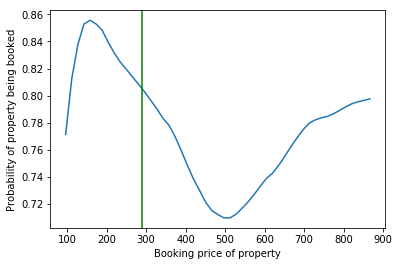

In [141]:
import matplotlib.pyplot as plt
for index, listing in X_test.sample(1, random_state=1).copy().iterrows():
    current_price = listing["price_calendar"]
    price_upper = 3 * current_price
    price_lower = (1/3) * current_price
    price_range = list(float_range(str(price_lower), str(price_upper), str((price_upper - price_lower)/50)))
    probs = []
    for price in price_range:
        listing["price_calendar"] = price
        prob = calc_average_prob_booked(listing)
        probs.append(prob)
    fig = plt.figure()
    plt.plot(list(price_range), probs)
    plt.ylabel('Probability of property being booked')
    plt.xlabel('Booking price of property')
    plt.axvline(x=current_price, color='g')
    plt.show()
    fig.savefig("price_")

I can see that although the plot does follow price elasticity curve near the current booking price of the property, it doesn't follow it beyond 500 price point. 

One of the reasons for this can be that we are using absolute value of the price for tuning it.

One of the assumption in the price elasticity curve is that all the other factors in the market should be held relatively constant and only the price of the property should be varying. Only then the relation between booking probability and price will follow the popular price elasticity curve in wide range of price variation.

The absolute value of price may have been increased in the dataset when the overall demand of properties for booking have increased. In such case, the property might be still getting booked at higher price duing the periods of higher demand. Therefore based on the dataset, our model will suggest that the probability of booking may also increase when the property price is increased. 

To tackle this issue, one workaround can be to normalize the price relative to all the other 100 properties that we are using in our training dataset to represent the competitive market environment conditions. Then we can observe the trend of change in probability along with the change in relative price and see it shows some price elasticity.

I will be updating the data preparation step in the next iteration of improving this project to tackle this issue by using normalized prices for training booking probability prediction models. The current implementation of price tuning assumes that all the properties have price elasticity.

Current price tuning method tries to decide a global threshold close to which it tries to move all the probabilities of the properties and decides the best value of threshold based on expected revenue maximization.

Another approach is to individually modify the price of each property such that maximum expected revenue is earned from that property. I am going to implement that strategy in next iteration of improving this price tuning method.

In [63]:
thresholds = list(float_range('0.025', '1', '0.025'))
revenue_by_threshold= pd.DataFrame({"revenue": 0}, index=thresholds)

In [62]:
def calc_revenue_at_tuned_price(row, threshold, classifiers):
    current_price = row["price_calendar"]
#     print("price_calendar: " + str(current_price))
    
    def calc_average_prob_booked(row):        
        df = pd.DataFrame(data=row.to_dict(), index=[0])
        sum_prob_booked = 0
        for clf in classifiers:
            sum_prob_booked += clf.predict_proba(df)[0][0]
        return sum_prob_booked/len(classifiers)
    patience = 50
    prob_booked = calc_average_prob_booked(row)
    
#     print ("probability of booked at price_calendar: " + str(prob_booked))
    if (prob_booked < threshold):
#         print ("Will try with reduced the price")
        trial_price = current_price
        saved_trial_price = trial_price
        steps_in_trap = 0
        while (prob_booked < threshold and trial_price > 10):
            trial_price = trial_price * 0.99
            row["price_calendar"] = trial_price
            prob_booked_trial = calc_average_prob_booked(row)
#             print ("trial_price: " + str(trial_price))
#             print ("prob_booked_trial: " + str(prob_booked_trial))

            if prob_booked_trial >= prob_booked:
                if prob_booked_trial == prob_booked:
                    steps_in_trap += 1
                    if steps_in_trap > patience:
                        return saved_trial_price * prob_booked
                else:
                    saved_trial_price = trial_price
                    steps_in_trap = 0
                prob_booked = prob_booked_trial
            else:
                steps_in_trap += 1
                if steps_in_trap > patience:
                    return saved_trial_price * prob_booked

        return trial_price * prob_booked
    else:
#         print ("Will try with increased the price")
        trial_price = current_price
        saved_trial_price = trial_price
        steps_in_trap = 0
        while (True):
            trial_price = trial_price * 1.01
            row["price_calendar"] = trial_price
            prob_booked_trial = calc_average_prob_booked(row)
#             print ("trial_price: " + str(trial_price))
#             print ("prob_booked_trial: " + str(prob_booked_trial))
            if prob_booked_trial <= prob_booked:
                if prob_booked_trial == prob_booked:
                    steps_in_trap += 1
                    if steps_in_trap > patience:
                        return saved_trial_price * prob_booked
                else:
                    saved_trial_price = trial_price
                    steps_in_trap = 0
                prob_booked = prob_booked_trial
                if (prob_booked > threshold and trial_price < 3 * current_price):
                    pass
                else:
                    return saved_trial_price * prob_booked    
            else:
                steps_in_trap += 1
                if steps_in_trap > patience:
                    return saved_trial_price * prob_booked

In [64]:
highest_revenue = -math.inf
threshold_at_highest_revenue = None
for threshold in thresholds:
#     print("====================================================\n")    
    print ("Evaluating expected revenue at threshold: " + str(threshold))
#     print("====================================================\n")
    revenue = 0
    for index, row in X_test.sample(n=100, random_state=42).copy().iterrows():
        revenue_at_tuned_price = calc_revenue_at_tuned_price(row, threshold, classifiers)
#         print ("threshold: " + str(threshold))
#         print ("revenue at tuned price: " + str(revenue_at_tuned_price))
        revenue += revenue_at_tuned_price
#         print ("------------------------------------------------------------")
    print ("Expected revenue: ", str(revenue))
    if revenue > highest_revenue:
        highest_revenue = revenue
        threshold_at_highest_revenue = threshold
    revenue_by_threshold.loc[threshold, "revenue"] = revenue

Evaluating expected revenue at threshold: 0.025
Expected revenue:  15684.28767090591
Evaluating expected revenue at threshold: 0.05
Expected revenue:  15680.40514813056
Evaluating expected revenue at threshold: 0.075
Expected revenue:  15681.124442491284
Evaluating expected revenue at threshold: 0.1
Expected revenue:  15689.653799255304
Evaluating expected revenue at threshold: 0.125
Expected revenue:  15697.528717478339
Evaluating expected revenue at threshold: 0.15
Expected revenue:  15720.602064757042
Evaluating expected revenue at threshold: 0.175
Expected revenue:  15719.68724362067
Evaluating expected revenue at threshold: 0.2
Expected revenue:  15740.617176625747
Evaluating expected revenue at threshold: 0.225
Expected revenue:  15759.09729224913
Evaluating expected revenue at threshold: 0.25
Expected revenue:  15776.240943320723
Evaluating expected revenue at threshold: 0.275
Expected revenue:  15785.582176043861
Evaluating expected revenue at threshold: 0.3
Expected revenue:  

In [65]:
revenue_by_threshold

,revenue
0.025,15684.287671
0.050,15680.405148
0.075,15681.124442
0.100,15689.653799
0.125,15697.528717
0.150,15720.602065
0.175,15719.687244
0.200,15740.617177
0.225,15759.097292
0.250,15776.240943


In [66]:
highest_revenue

15921.857007186476

In [67]:
threshold_at_highest_revenue

0.5

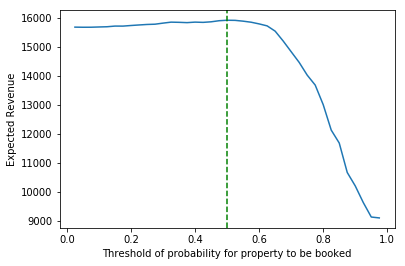

In [145]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(revenue_by_threshold.index, revenue_by_threshold)
plt.ylabel('Expected Revenue')
plt.xlabel('Threshold of probability for property to be booked')
plt.axvline(x=threshold_at_highest_revenue, color='g', linestyle="--")
plt.show()
fig.savefig("images/expected_revenue_vs_threshold.png")
plt.close()

Calculating percentage of change in expected revenue before and after tuning price using occupancy prediction model.

In [69]:
expected_revenue_original_price = 0
expected_revenue_modified_price = 0

for index, row in X_test.sample(n=100, random_state=42).copy().iterrows():
    def calc_average_prob_booked(row):        
        df = pd.DataFrame(data=row.to_dict(), index=[0])
        sum_prob_booked = 0
        for clf in classifiers:
            sum_prob_booked += clf.predict_proba(df)[0][0]
        return sum_prob_booked/len(classifiers)
    prob_booked = calc_average_prob_booked(row)
    expected_revenue_original_price += prob_booked    * row["price_calendar"]
    revenue_at_tuned_price = calc_revenue_at_tuned_price(row, threshold_at_highest_revenue, classifiers)
    expected_revenue_modified_price += revenue_at_tuned_price

In [70]:
percentag_change = 100*(expected_revenue_modified_price - expected_revenue_original_price)/expected_revenue_original_price

In [71]:
percentag_change

58.53088419507424

The above value of percentage change of expected revenue that can be achieved by tuning the prices shows the potential of increasing the expected revenue by tuning prices using booking probability prediction model. 

Although there are two caveats:
- currently it assumes that all the booking probability prediciton model shows price elasticity for all the property listings, which is not actually the case.
- Instead of maximizing expected revenue from each individual property, it tries to find a global threshold value such that moving the booking proability of all the properties closer to it by tuning the price.

In the next iteration of improving this project, I am considering to check whether the given property demonstrates price elasticity. If yes, then try to maximize the expected revenue from that property by tuning its price in near by value of its current price.

### TODO
Implement second approach for tuning price to maximise expected revenue from each individual property.